# 0.) Import the Credit Card Fraud Data From CCLE

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_csv("/Users/adrianonggowarsito/Desktop/fraudTest.csv")

In [3]:
df.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2020-06-21 12:14:25,2291163933867244,fraud_Kirlin and Sons,personal_care,2.86,Jeff,Elliott,M,351 Darlene Green,...,33.9659,-80.9355,333497,Mechanical engineer,1968-03-19,2da90c7d74bd46a0caf3777415b3ebd3,1371816865,33.986391,-81.200714,0
1,1,2020-06-21 12:14:33,3573030041201292,fraud_Sporer-Keebler,personal_care,29.84,Joanne,Williams,F,3638 Marsh Union,...,40.3207,-110.4360,302,"Sales professional, IT",1990-01-17,324cc204407e99f51b0d6ca0055005e7,1371816873,39.450498,-109.960431,0
2,2,2020-06-21 12:14:53,3598215285024754,"fraud_Swaniawski, Nitzsche and Welch",health_fitness,41.28,Ashley,Lopez,F,9333 Valentine Point,...,40.6729,-73.5365,34496,"Librarian, public",1970-10-21,c81755dbbbea9d5c77f094348a7579be,1371816893,40.495810,-74.196111,0
3,3,2020-06-21 12:15:15,3591919803438423,fraud_Haley Group,misc_pos,60.05,Brian,Williams,M,32941 Krystal Mill Apt. 552,...,28.5697,-80.8191,54767,Set designer,1987-07-25,2159175b9efe66dc301f149d3d5abf8c,1371816915,28.812398,-80.883061,0
4,4,2020-06-21 12:15:17,3526826139003047,fraud_Johnston-Casper,travel,3.19,Nathan,Massey,M,5783 Evan Roads Apt. 465,...,44.2529,-85.0170,1126,Furniture designer,1955-07-06,57ff021bd3f328f8738bb535c302a31b,1371816917,44.959148,-85.884734,0


In [4]:
df_select = df.copy()

In [5]:
df_select = df_select[
    ["trans_date_trans_time", "category", "amt", "city_pop", "is_fraud"]
]

In [6]:
df_select["trans_date_trans_time"] = pd.to_datetime(
    df_select.trans_date_trans_time
)

In [7]:
df_select["time_var"] = [
    i.second for i in df_select["trans_date_trans_time"]
]

In [8]:
X = pd.get_dummies(df_select, columns=["category"])
X = X.drop(["trans_date_trans_time", "is_fraud"], axis = 1)

In [9]:
y = df["is_fraud"]

# 1.) Use scikit learn preprocessing to split the data into 70/30 in out of sample

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [11]:
# Splitting the data between training and testing.
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    random_state=999
)

In [12]:
# Splitting the testing data between testing and holdout.
X_test, X_holdout, y_test, y_holdout = train_test_split(
    X_test, y_test,
    test_size=0.5
)

# 2.) Make three sets of training data (Oversample, Undersample and SMOTE)

In [13]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

In [14]:
# Create the oversampled training data
over_sampler = RandomOverSampler(random_state=999)
X_over, y_over = over_sampler.fit_resample(X_train, y_train)

# Create the undersampled training data
under_sampler = RandomUnderSampler(random_state=999)
X_under, y_under = under_sampler.fit_resample(X_train, y_train)

# Apply SMOTE to your training data
smote = SMOTE(random_state=999)
smote_X, smote_y = smote.fit_resample(X_train, y_train)

# 3.) Train three logistic regression models

In [15]:
# Define the pipeline for the logistic regression model with oversampling
log_over = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=999))
])
# Fit the model on the oversampled dataset
log_over.fit(X_over, y_over)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(random_state=999))])

In [16]:
# Define the pipeline for the logistic regression model with undersampling
log_under = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression(random_state=999))
])
# Fit the model on the undersampled dataset
log_under.fit(X_under, y_under)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', LogisticRegression(random_state=999))])

In [17]:
# Define the pipeline for the logistic regression model with SMOTE
log_smote = Pipeline([
    ('scaler', StandardScaler()),
    ('balancer', SMOTE(random_state=999)),
    ('model', LogisticRegression(random_state=999))
])
# Fit the model on the original training dataset since SMOTE is part of the pipeline
log_smote.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('balancer', SMOTE(random_state=999)),
                ('model', LogisticRegression(random_state=999))])

# 4.) Test the three models

In [18]:
def print_scores(x, y, over, under, smote, title = 'Out of Sample'):
    # Calculating the score
    over = over.score(x, y)
    under = under.score(x, y)
    smote = smote.score(x, y)
    
    temp = f"""
    Test Scores for {title}
    Accuracy
    --------
    - Over Sample: {over:.4f}
    - Under Sample: {under:.4f}
    - SMOTE: {smote:.4f}
    """
    print(temp)

Testing the three models in-sample.

In [19]:
print_scores(
    X_train, y_train,
    log_over, log_under, log_smote,
    title = 'In-Sample'
)


    Test Scores for In-Sample
    Accuracy
    --------
    - Over Sample: 0.9126
    - Under Sample: 0.8948
    - SMOTE: 0.9067
    


Testing the three models out-sample.

In [20]:
print_scores(
    X_test, y_test,
    log_over, log_under, log_smote,
    title = 'Out-Sample'
)


    Test Scores for Out-Sample
    Accuracy
    --------
    - Over Sample: 0.9116
    - Under Sample: 0.8949
    - SMOTE: 0.9062
    


In [21]:
# We see SMOTE performing with higher accuracy but is ACCURACY really the best measure?

Accuracy is not the best measure for this dataset. We are more concerned about to detect fraud, so we want to maximize the number of true positives and minimize the number of false negatives. In other words, we want to maximize the sensitivity (recall) and minimize the false negative rate.

# 5.) Which performed best in Out of Sample metrics?

In [22]:
print_scores(
    X_holdout, y_holdout,
    log_over, log_under, log_smote,
    title = 'HoldOut-Sample'
)


    Test Scores for HoldOut-Sample
    Accuracy
    --------
    - Over Sample: 0.9138
    - Under Sample: 0.8959
    - SMOTE: 0.9079
    


Analyzing the out of sample and holdout accurracy, we see that oversample is better, followed by SMOTE.

In [23]:
# Sensitivity here in credit fraud is more important as seen from last class

In [24]:
from sklearn.metrics import confusion_matrix

In [25]:
y_true = y_test

In [26]:
# Assuming y_test is already defined

# Over-sampling model predictions and sensitivity
y_pred_over = log_over.predict(X_test)
cm_over = confusion_matrix(y_test, y_pred_over)
print("Over Sample Sensitivity : ", cm_over[1,1] / (cm_over[1,0] + cm_over[1,1]))

# Under-sampling model predictions and sensitivity
y_pred_under = log_under.predict(X_test)
cm_under = confusion_matrix(y_test, y_pred_under)
print("Under Sample Sensitivity : ", cm_under[1,1] / (cm_under[1,0] + cm_under[1,1]))

# SMOTE model predictions and sensitivity
y_pred_smote = log_smote.predict(X_test)
cm_smote = confusion_matrix(y_test, y_pred_smote)
print("SMOTE Sample Sensitivity : ", cm_smote[1,1] / (cm_smote[1,0] + cm_smote[1,1]))

Over Sample Sensitivity :  0.70625
Under Sample Sensitivity :  0.70625
SMOTE Sample Sensitivity :  0.709375


# 6.) Pick two features and plot the two classes before and after SMOTE.

In [27]:
raw_temp = pd.concat([X_train, y_train], axis =1)

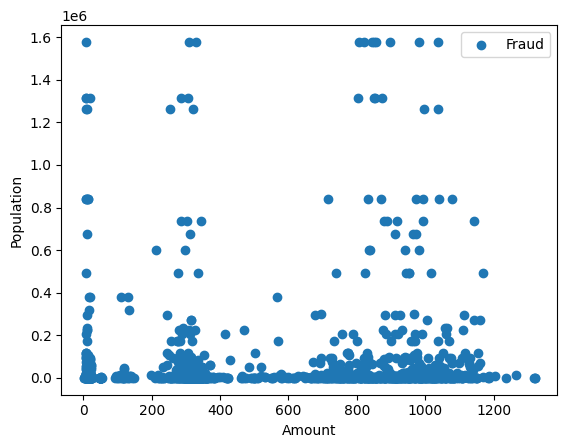

In [28]:
#plt.scatter(raw_temp[raw_temp["is_fraud"] == 0]["amt"], raw_temp[raw_temp["is_fraud"] == 0]["city_pop"])

plt.scatter(raw_temp[raw_temp["is_fraud"] == 1]["amt"], raw_temp[raw_temp["is_fraud"] == 1]["city_pop"])
plt.legend(["Fraud", "Not Fraud"])
plt.xlabel("Amount")
plt.ylabel("Population")

plt.show()

In [29]:
raw_temp = pd.concat([smote_X, smote_y], axis=1)

/Users/adrianonggowarsito/anaconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


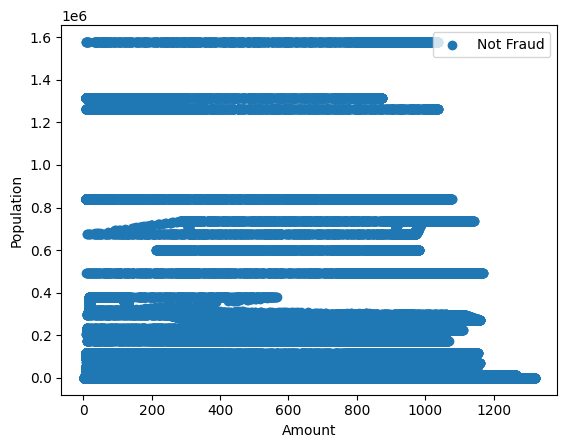

In [30]:
#plt.scatter(raw_temp[raw_temp["is_fraud"] == 0]["amt"], raw_temp[raw_temp["is_fraud"] == 0]["city_pop"])

plt.scatter(raw_temp[raw_temp["is_fraud"] == 1]["amt"], raw_temp[raw_temp["is_fraud"] == 1]["city_pop"])
plt.legend([ "Not Fraud", "Fraud"])
plt.xlabel("Amount")
plt.ylabel("Population")

plt.show()

# 7.) We want to compare oversampling, Undersampling and SMOTE across our 3 models (Logistic Regression, Logistic Regression Lasso and Decision Trees).

# Make a dataframe that has a dual index and 9 Rows.
# Calculate: Sensitivity, Specificity, Precision, Recall and F1 score. for out of sample data.
# Notice any patterns across perfomance for this model. Does one totally out perform the others IE. over/under/smote or does a model perform better DT, Lasso, LR?
# Choose what you think is the best model and why. test on Holdout

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import pandas as pd

In [32]:
model_configs = {
    'log': LogisticRegression(),
    'lasso': LogisticRegression(
        penalty = 'l1', C = 0.5, solver = 'liblinear'
    ),
    'tree': DecisionTreeClassifier()
}

balancing_configs = {
    'over': RandomOverSampler(),
    'under': RandomUnderSampler(),
    'smote': SMOTE()
}

In [33]:
trained_models = {}
scores_for_df = {}

In [34]:
for i,j in balancing_configs.items():
    for k,l in model_configs.items():
        pipe = Pipeline(
            steps=[
                ('scaler', StandardScaler()),
                ('balancer', j),
                ('model', l)
            ]
        )
        pipe.fit(X_train, y_train)
        trained_models[(i,k)] = pipe
        # Compute precision, recall, f1 score and store them in a dictionary
        y_pred = pipe.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
        sensitivity = cm[1,1] /( cm[1,0] + cm[1,1])
        specificity = cm[0,0] /( cm[0,0] + cm[0,1])
        accuracy = pipe.score(X_test, y_test)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        scores_for_df[(i,k)] = {
            'precision': precision,
            'recall': recall,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'accuracy': accuracy,
            'f1': f1,
        }

In [35]:
pd.DataFrame(scores_for_df).T

precision    recall  sensitivity  specificity  accuracy        f1
over  log     0.029562  0.706250     0.706250     0.910655  0.909871  0.056748
      lasso   0.029817  0.709375     0.709375     0.911053  0.910279  0.057229
      tree    0.584615  0.475000     0.475000     0.998699  0.996689  0.524138
under log     0.030534  0.712500     0.712500     0.912823  0.912054  0.058559
      lasso   0.034721  0.706250     0.706250     0.924336  0.923499  0.066188
      tree    0.065563  0.928125     0.928125     0.949023  0.948943  0.122474
smote log     0.029006  0.709375     0.709375     0.908488  0.907723  0.055733
      lasso   0.029573  0.709375     0.709375     0.910294  0.909523  0.056778
      tree    0.259080  0.668750     0.668750     0.992630  0.991387  0.373473

Looking at the provided scores, if we prioritize F1 score (a balanced metric for precision and recall), the Decision Tree classifier with undersampling ("under_tree") seems to perform the best. It has the highest F1 score, indicating a good balance between precision and recall. It also has the highest recall, which is crucial for fraud detection as it's more important to catch as many frauds as possible.

However, the trade-off is that it has a lower specificity compared to the other models, which means it is more likely to incorrectly label non-fraudulent transactions as fraudulent. Depending on the cost and impact of false positives, this might be an acceptable trade-off.

On the other hand, if we want to maintain higher specificity (reducing false positives), SMOTE has a slightly lower recall but better specificity than undersampling.